## Linear regression using scikit-learn package

#### 1. Import package and load data

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import sys
sys.path.append("../src")
import utils
np.set_printoptions(precision=2)

In [2]:
df = pd.read_csv("../data/raw/USA_Housing.csv")
df.head()

,Area Income,House Age,Number of Rooms,Number of Bedrooms,Area Population,Price,Address
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.24005,7.188236,5.586729,3.26,34310.24283,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.19723,5.040555,7.839388,4.23,26354.10947,6.309435e+05,USNS Raymond\nFPO AE 09386


### 2. Data pre-processing 
- Slpit data into trainning, cross validation and test set
- Perform data standardization

In [3]:
X_features = ['Area Income', 'House Age', 'Number of Rooms', 'Area Population']
X = df[X_features]
y = df["Price"]

x_train, x_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=1)  # Get 60% of the dataset as the training set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1) # Split the 40% subset into cross validation and test set
del x_, y_  # Delete temporary variables

In [4]:
# data standardization
linear_scaler = StandardScaler()
x_train_scaled = linear_scaler.fit_transform(x_train)

#### 3. Train model with SGDRegressor
- Train model, report training and cross validation MSE
- Choose polynomial feature

In [5]:
sgdr = SGDRegressor(loss="squared_error", max_iter=1000)  # max_iter = np.ceil(10**6/ len(y))
sgdr.fit(x_train_scaled, y_train)

# print(sgdr)
print(f"Number of iterations completed: {sgdr.n_iter_}, number of weight updates: {sgdr.t_}")
print(f"Model parameters: \n\tw: {sgdr.coef_}, \n\tb: {sgdr.intercept_}")

y_pred_gd = sgdr.predict(x_train_scaled)
print(f"Training MSE: {mean_squared_error(y_train, y_pred_gd) / 2}")

# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_scaled = linear_scaler.transform(x_cv)
yhat = sgdr.predict(X_cv_scaled)  # Feed the scaled cross validation set
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")


Number of iterations completed: 14, number of weight updates: 42001.0
Model parameters: 
	w: [228202.96 162858.   123455.75 150986.13], 
	b: [1227914.48]
Training MSE: 4982185419.0673275
Cross validation MSE: 5404795086.966767


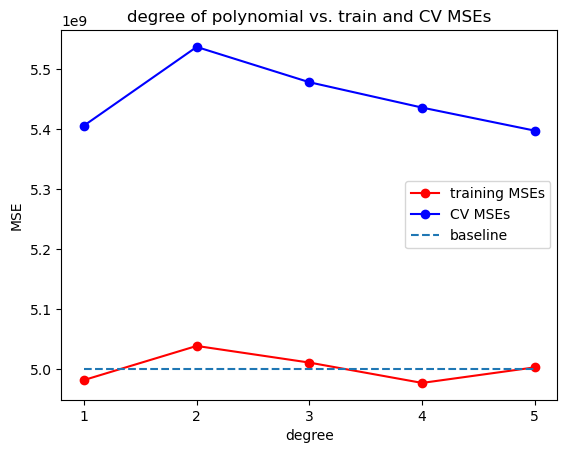

Lowest CV MSE is found in the model with degree=5
Corresponding training MSE: 5003332512.04
Corresponding cross validation MSE: 5397084349.04


In [6]:
sgdr_n = SGDRegressor()
s_degrees, s_train_mses, s_cv_mses, s_scaler, s_models = utils.train_poly(sgdr_n, x_train, y_train, x_cv, y_cv, max_degree=5)
utils.plot_train_cv_mses(s_degrees, s_train_mses, s_cv_mses, baseline=5e9)

degree = np.argmin(s_cv_mses) + 1
print(f"Lowest CV MSE is found in the model with degree={degree}")
print(f"Corresponding training MSE: {s_train_mses[degree-1]:.2f}")
print(f"Corresponding cross validation MSE: {s_cv_mses[degree-1]:.2f}")

#### 4. Train model with LinearRegression
- Train model, report training and cross validation MSE
- Choose polynomial feature

In [7]:
# Linear regression using a close form solution based on the normal equation
linear_model = LinearRegression()
linear_model.fit(x_train_scaled, y_train)

# print(linear_model)
print(f"Model parameters: \n\tw: {linear_model.coef_}, \n\tb: {linear_model.intercept_}")

y_pred_lm = linear_model.predict(x_train_scaled)  # predict
print(f"Training MSE: {mean_squared_error(y_train, y_pred_lm) / 2}")

# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_scaled = linear_scaler.transform(x_cv)
yhat = linear_model.predict(X_cv_scaled)  # Feed the scaled cross validation set
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

Model parameters: 
	w: [227034.5  162719.01 123123.31 150814.5 ], 
	b: 1228902.7814884933
Training MSE: 4980946918.478754
Cross validation MSE: 5403410856.265396


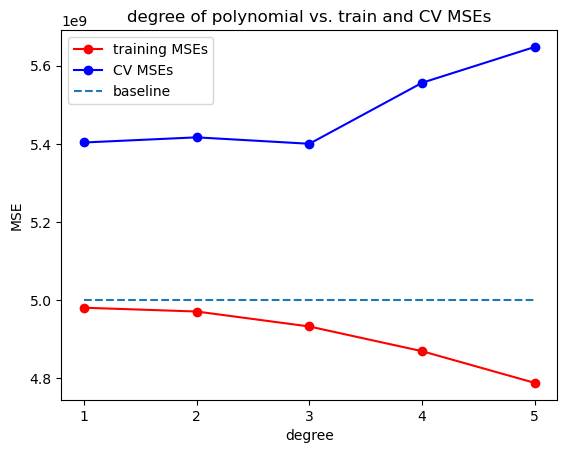

Lowest CV MSE is found in the model with degree=3
Corresponding training MSE: 4932952099.49
Corresponding cross validation MSE: 5400141901.75


In [8]:
# Train and plot polynomial regression models
linear_n = LinearRegression()
l_degrees, l_train_mses, l_cv_mses, l_scalers, l_models = utils.train_poly(linear_n, x_train, y_train, x_cv, y_cv, max_degree=5)
utils.plot_train_cv_mses(l_degrees, l_train_mses, l_cv_mses, baseline=5e9)

degree = np.argmin(l_cv_mses) + 1
print(f"Lowest CV MSE is found in the model with degree={degree}")
print(f"Corresponding training MSE: {l_train_mses[degree-1]:.2f}")
print(f"Corresponding cross validation MSE: {l_cv_mses[degree-1]:.2f}")

### 5. Model selection
- Choose model and polynominal features
- Report test MSE

In [9]:
print('Comparing cross validation MSE, choose Linear Regression model')
degree = np.argmin(l_cv_mses) + 1
# Add polynomial features to the test set
poly = PolynomialFeatures(degree, include_bias=False)
X_test_mapped = poly.fit_transform(x_test)

# Scale the test set
X_test_mapped_scaled = l_scalers[degree-1].transform(X_test_mapped)

# Compute the test MSE
yhat = l_models[degree-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Training MSE: {l_train_mses[degree-1]:.2f}")
print(f"Cross Validation MSE: {l_cv_mses[degree-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

Comparing cross validation MSE, choose Linear Regression model
Training MSE: 4932952099.49
Cross Validation MSE: 5400141901.75
Test MSE: 5297619968.98


#### 6. Learning curve
- The following learning curve calculated using the training dataset to give an idea of how well the model is learning

#### Results: 
- The model has both high bias and high variance problem
- The gap for the training and validation curve becomes mall as the training dataset size increases. This indicates that adding more examples to our model is not going to improve its performance. 
- The training MSE is very high, which indicates a high variance problem

#### To fix these problems,
- Add more features
- Train different models

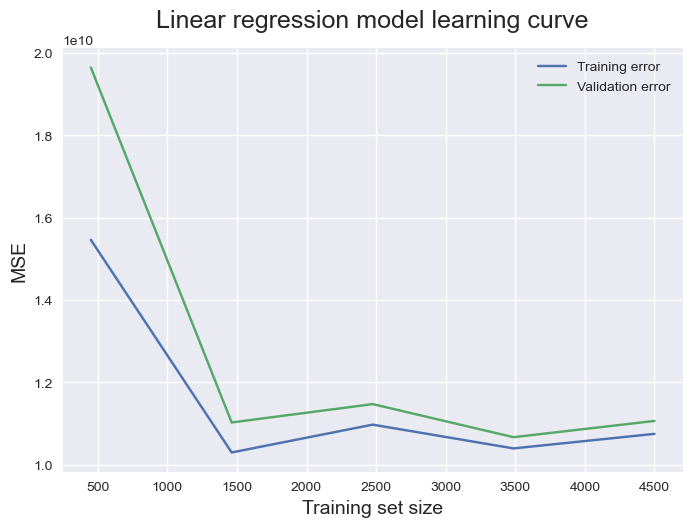

In [10]:
poly = PolynomialFeatures(3)
x_ = poly.fit_transform(X)
x_scaled = StandardScaler().fit_transform(x_)
utils.plot_learning_curve(x_scaled, y, LinearRegression(), random_state=5)
